In [1]:
import Pkg
# Pkg.activate("./dibs_env")
Pkg.activate("/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env")
ENV["PYTHON"]=""
Pkg.build("PyCall")

  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env`
    Building Conda ─→ `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/6e47d11ea2776bc5627421d59cdcc1296c058071/build.log`
    Building PyCall → `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/53b8b07b721b77144a0fbbbc2675222ebf40a02d/build.log`


In [2]:
install_run = true
if install_run
    using Pkg
    Pkg.add(["Glob","FITSIO","Serialization", "HDF5", "DelimitedFiles"])
    Pkg.add(["StatsBase","Distributions","FreqTables", "LsqFit", "KrylovKit"])
    Pkg.add(["BinnedStatistics","KrylovKit","ImageTransformations", "Interpolations"])
    Pkg.add(["DataFrames", "ProgressMeter", "Distributed", "BenchmarkTools"])
    Pkg.add(["Healpix", "SkyCoords", "WCS"])
    Pkg.add(["LaTeXStrings", "Formatting", "Printf", "PyFormattedStrings"])
    Pkg.add(["Conda","PyCall","PyPlot", "Plots"])
end

#File Handling
using Glob, FITSIO, Serialization, HDF5, DelimitedFiles
# Stats
using StatsBase, LinearAlgebra, Distributions, FreqTables, LsqFit 
using BinnedStatistics, KrylovKit, ImageTransformations
# Computing
using DataFrames, ProgressMeter, Distributed, BenchmarkTools, Random, Interpolations
# Astro
using Healpix, SkyCoords, WCS
# Python Plotting Setup
using PyCall, LaTeXStrings, Formatting, Printf, PyFormattedStrings
using PyPlot, Plots
import PyPlot; const plt = PyPlot
mpltk=pyimport("mpl_toolkits.axes_grid1")
patches=pyimport("matplotlib.patches")
mplcolors=pyimport("matplotlib.colors")
mplani = pyimport("matplotlib.animation");
cc=pyimport("colorcet")
pyimport("sys")."stdout" = PyTextIO(stdout)
pyimport("sys")."stderr" = PyTextIO(stderr);
py"""
from scipy.stats import binned_statistic_2d
"""
plt.matplotlib.style.use("default")

    Updating registry at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Project.toml`
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Manifest.toml`
   Resolving package versions...
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Project.toml`
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Manifest.toml`
   Resolving package versions...
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Project.toml`
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Manifest.toml`
   Resolving package versions...
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Project.toml`
  No Changes to `/uufs/

In [3]:
andrew_dir = "/uufs/chpc.utah.edu/common/home/u6039752/scratch/zenodo/GaiaDIB/GaiaDIB_dat/"

star_msk, nansum = deserialize(andrew_dir*"priors/star_mask.jdat");
SNR_lst = h5read(andrew_dir*"priors/SNR_lst.h5","SNR_lst");
sig_noise = deserialize(andrew_dir*"priors/sig_noise.jdl")

delthres = 1.46
noisefact = 3.6;
chi2perdof = 0.15
covdet = h5read(andrew_dir*"priors/precomp_dust_2_analyticDeriv.h5","covdet")
covdet0 = median(covdet)

c = 299792.458; # in km/s
cwave = 8623.14
cwave_cent = 8623.47 # this was the center of the scan, not the actual cwave
mu0, sig0 = 1.85, 0.5
mu1, sig1 = 8623.47, 1

srng = -100:0.1:100
sigrng = 0.4:0.01:4;

xmin0 = 8460
xmax0 = 8700
wavex = xmin0:0.1:xmax0
maxw = maximum(wavex[star_msk])
minw = minimum(wavex[star_msk])

waveknown = [8618.647, 8619.457, 8620.792, 8623.969];
labknown =["FeI]", "SI", "TiI", "FeI"]
waveadd = [8620.508, 8622.438]
labadd = ["FeI", "NiI"]
wavebad = [8617.75, 8621.62, 8625.236, 8627.73]
labbad = ["CaI", "CaI]","FeI]","TiIII"]
wavelst = [waveknown, waveadd, wavebad, cwave]
lablst = [labknown, labadd, labbad,["DIB"]]
wavecolor = ["turquoise", "turquoise", "magenta", "black"];

In [4]:
cmap_wb = plt.cm.get_cmap("cet_CET_L16_r",512)
cmap_wb.set_bad(color=(0.7,0.7,0.7))

cmap_wb_u = plt.cm.get_cmap("cet_CET_L16_r",512)
cmap_wb_u.set_bad(color=(0.7,0.7,0.7))
cmap_wb_u.set_under(color=(0.7,0.7,0.7))

cmap_bwr = plt.cm.get_cmap("cet_CET_D1A",512)
cmap_bwr.set_bad(color=(0.7,0.7,0.7))

cmap_bwrg = plt.cm.get_cmap("cet_CET_D1",512)
cmap_bwrg.set_bad(color=(0.7,0.7,0.7))
cmap_bwrg.set_under(color=(0.5,0.8,0.5))
cmap_bwrg.set_over(color=(0.4,0.4,0.4))

cmap_exp = plt.cm.get_cmap("cet_CET_L12_r",512)
cmap_exp.set_bad(color=(0.6,0.6,0.6))

py"""
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap_text, minval=0.0, maxval=1.0, n=100):
    cmap = (plt.get_cmap(cmap_text,512)).copy()
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
"""

trunc_cmap_L6 = py"truncate_colormap('cet_CET_L6', 0.8, 0.0)"
trunc_warm_cmap = py"truncate_colormap('cet_CET_L8', 0.1, 0.9)";

py"""
import numpy as np
import matplotlib.colors as mcolors
colors = plt.cm.get_cmap("cet_CET_L6",512)(np.linspace(0.9,0.5,256))
colors = np.append(colors,plt.cm.get_cmap("cet_CET_L4",512)(np.linspace(0.5,0,256)),axis=0)
cmap_split = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=512)
"""
cmap_split = py"cmap_split"

py"""
import numpy as np
import matplotlib.colors as mcolors 
colors = [(0,0,0,0) for c in np.linspace(0,0.5,100)]
cmap_test = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
"""
cmap_test = py"cmap_test";

cmap_test.set_bad(color=(0.7,0.7,0.7))
cmap_test.set_under(color=(0.5,0.8,0.5))
cmap_test.set_over(color=(0.4,0.4,0.4));

In [1]:
!ls

LoadError: UndefVarError: ls not defined

In [5]:
function colat_long_rad(glonin,glatin)
    return π/2 .- deg2rad(glatin), deg2rad(glonin)
end

function project_VLSR(u,v,w; rGVLSR = (10.6,10.7,7.6))
    return dot(rGVLSR,[u,v,w])
end

function trans(x)
    if x>180
        return x-360
    else
        return x
    end
end

fiqr(x) = iqr(x)./1.34896;

In [6]:
# MADGICS Catalog
f = h5open(andrew_dir*"dib_explore_v14.h5");
glon = read(f["glon"])
glat = read(f["glat"]);

U = read(f["U"])
V = read(f["V"])
W = read(f["W"])

X = read(f["X"])
Y = read(f["Y"])

ew = read(f["ew"])
ew_err = read(f["ew_err"])

lam = read(f["lam"])
lam_err = read(f["lam_err"]);

vdust = read(f["v_dust_lsr"]);
v_dust_lsr_COframe = read(f["v_dust_lsr_COframe"])
v_dust_lsr_err = read(f["v_dust_lsr_err"]);
v_star_bary = read(f["v_star_bary"])
v_star_bary_error = read(f["v_star_bary_error"])

sig = read(f["sig"])
sig_err = read(f["sig_err"]);

dib_snr = read(f["dib_snr"])
stellar_snr = read(f["stellar_snr"])

d_pc = read(f["r_med_geo"])
dkpc = d_pc./1000
r_lo_geo = read(f["r_lo_geo"])
r_hi_geo = read(f["r_hi_geo"]);

bayestar19 = read(f["bayestar19"])
close(f)

glon_trans = trans.(glon);

In [7]:
py"""
from dustmaps.config import config
config.reset()
"""

In [8]:
f = FITS(andrew_dir*"gaia_archive_results/RVS_astro-result.fits.gz")
RVS_source_id = read(f[2],"source_id")
ps = sortperm(RVS_source_id);
flags_gspspec = read(f[2],"flags_gspspec")[ps];
teff = read(f[2],"teff_gspspec")[ps]
logg = read(f[2],"logg_gspspec")[ps]
mh = read(f[2],"mh_gspspec")[ps]
close(f)

grvs = h5open(andrew_dir*"sources/gaia_rvs_lite.h5");
grvs_id = read(grvs["SOURCE_ID"]);
glon_rvs = read(grvs["GLON"]);
glat_rvs = read(grvs["GLAT"]);
# glat_teff = read(grvs["T_EFF"]);
close(grvs)

py"""
from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.sfd import SFDWebQuery
sfd = SFDWebQuery()
l = $glon_rvs
b = $glat_rvs
coords = SkyCoord(l*units.deg, b*units.deg, frame='galactic')
sfd_reddening = sfd(coords)
"""

sfd_red = 1 .* py"sfd_reddening";

In [9]:
function mask_gspspec_flag(flagstring)
    good = true
    if length(flagstring)==41
        for i=1:13
            good &= (flagstring[i].=='0')
        end
        return good
    else
        good = false
        return good
    end
end

mask_gspspec_flag (generic function with 1 method)

In [10]:
msk_flags_gspspec = mask_gspspec_flag.(flags_gspspec);

msk_inter = nansum .& (sfd_red.<0.05) .& msk_flags_gspspec
count(msk_inter), count(msk_inter)/length(msk_inter)

(65186, 0.06520914924798303)

In [11]:
ps1 = sortperm(SNR_lst[msk_inter]);


In [12]:
basework = "/uufs/chpc.utah.edu/common/home/u6039752/scratch/working/"

fluxes = h5read(basework*"2022_11_28/sources/gaia_rvs.h5", "flux");
dfluxes = h5read(basework*"2022_11_28/sources/gaia_rvs.h5", "dflux");

In [13]:
masked_fluxes = fluxes[star_msk,msk_inter][:,ps1];
masked_dfluxes = dfluxes[star_msk,msk_inter][:,ps1];
masked_teffs = teff[msk_inter][ps1];
masked_logg = logg[msk_inter][ps1];
masked_mh = mh[msk_inter][ps1];
masked_snrs = SNR_lst[msk_inter][ps1];

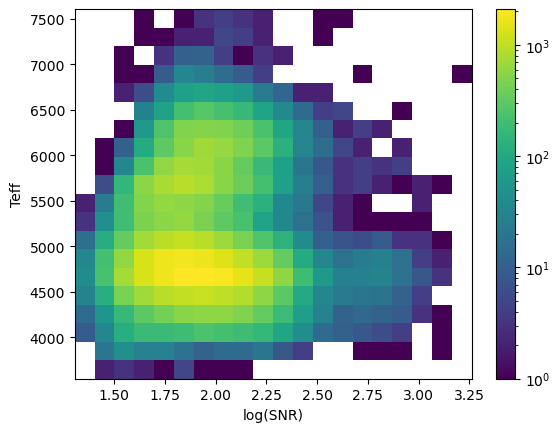

PyObject Text(24.0, 0.5, 'Teff')

In [14]:
plt.hist2D(log10.(SNR_lst[msk_inter][ps1]), masked_teffs, bins=20, norm = mplcolors.LogNorm())
plt.colorbar()
plt.xlabel("log(SNR)")
plt.ylabel("Teff")

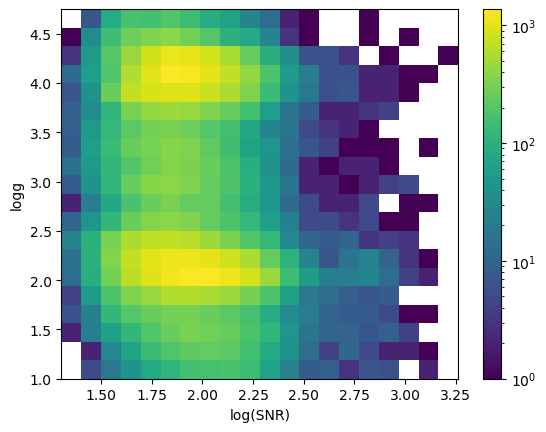

PyObject Text(24.000000000000007, 0.5, 'logg')

In [15]:
plt.hist2D(log10.(SNR_lst[msk_inter][ps1]), masked_logg, bins=20, norm = mplcolors.LogNorm())
plt.colorbar()
plt.xlabel("log(SNR)")
plt.ylabel("logg")

In [16]:
my_residuals = h5read("../all_gaia_masked/all_files_in_order.h5", "residuals")[star_msk,1:size(masked_fluxes,2)][:,ps1];
my_stellar_components = h5read("../all_gaia_masked/all_files_in_order.h5", "star_components")[star_msk,1:size(masked_fluxes,2)][:,ps1];

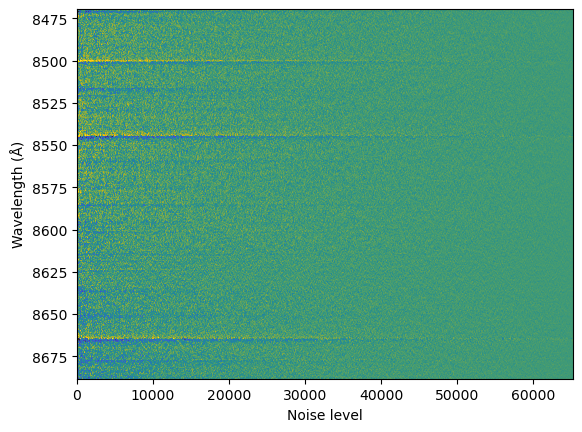

PyObject Text(25.953125, 0.5, 'Wavelength (Å)')

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(100*(my_residuals./my_stellar_components),
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-2,
    vmax=2,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(my_residuals,2),maxw,minw),
)
plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

In [18]:
size(100*(my_residuals./my_stellar_components)[:,1:200])

(2189, 200)

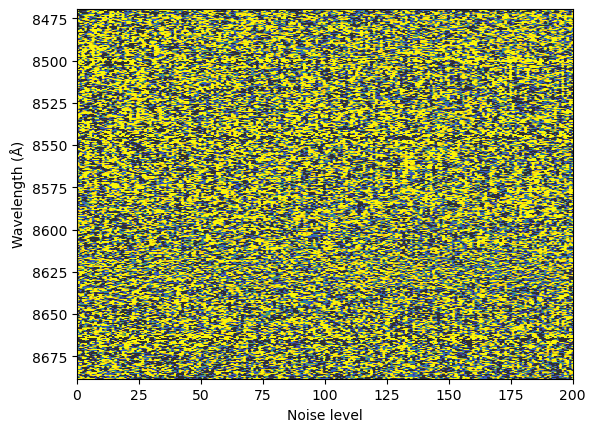

PyObject Text(25.953125, 0.5, 'Wavelength (Å)')

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(100*(my_residuals./my_stellar_components)[:,1:200],
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-2,
    vmax=2,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(my_residuals[:,1:200],2),maxw,minw),
)
plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

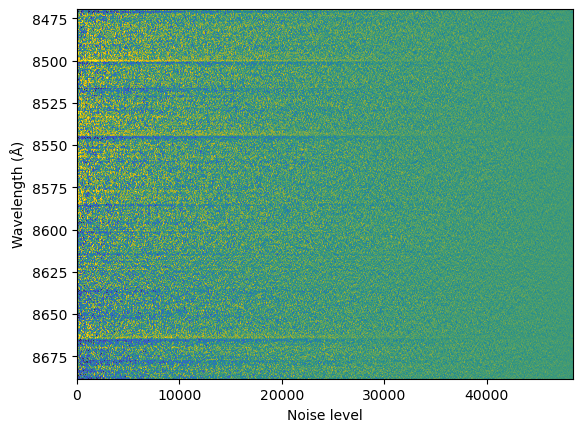

PyObject Text(25.953125, 0.5, 'Wavelength (Å)')

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

temp_mask = masked_teffs .< 5500

img = ax.imshow(my_residuals[:,temp_mask],
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-0.01,
    vmax=0.01,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(my_residuals[:,temp_mask],2),maxw,minw),
)
plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

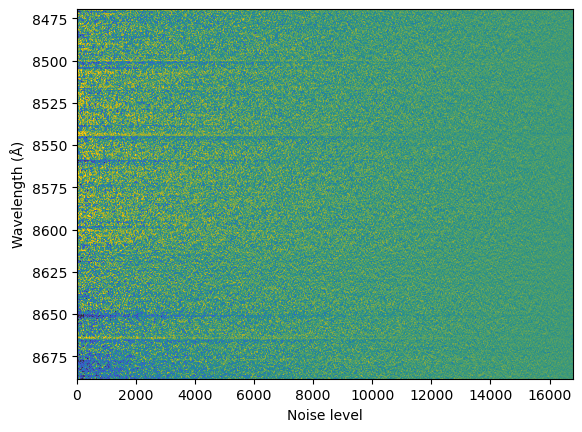

PyObject Text(25.953125, 0.5, 'Wavelength (Å)')

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

temp_mask = masked_teffs .> 5500

img = ax.imshow(my_residuals[:,temp_mask],
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-0.01,
    vmax=0.01,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(my_residuals[:,temp_mask],2),maxw,minw),
)
plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

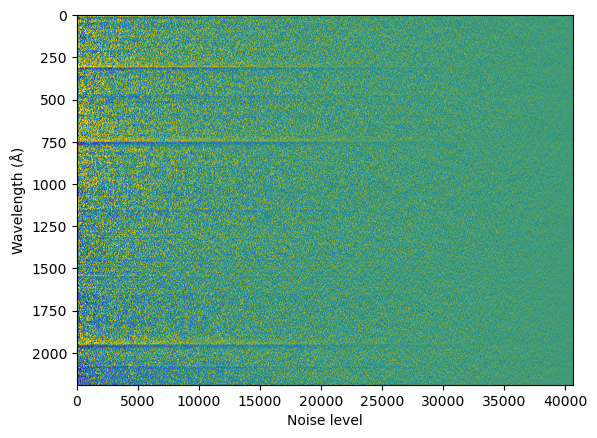

PyObject Text(25.953125, 0.5, 'Wavelength (Å)')

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

logg_mask = masked_logg .< 3.5

img = ax.imshow(my_residuals[:,logg_mask],
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-0.01,
    vmax=0.01,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    # extent=(0,size(sorted_residuals',2),maxw,minw),
)
plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

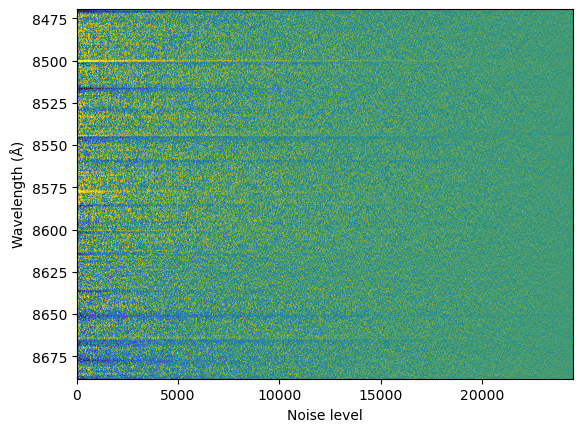

PyObject Text(25.953125, 0.5, 'Wavelength (Å)')

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

logg_mask = masked_logg .> 3.5

img = ax.imshow(my_residuals[:,logg_mask],
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-0.01,
    vmax=0.01,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(my_residuals[:,logg_mask],2),maxw,minw),
)
plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

In [24]:
size(my_residuals)

(2189, 65186)

Use the 20,000 lowest SNR stars to make a template. SNR is ordered lowest to highest, so that's the first 20,000 stars.

In [25]:
template = mean(my_residuals[:,1:20000], dims=2);
template_length = sqrt(sum(template.^2))
unit_template = template/template_length;

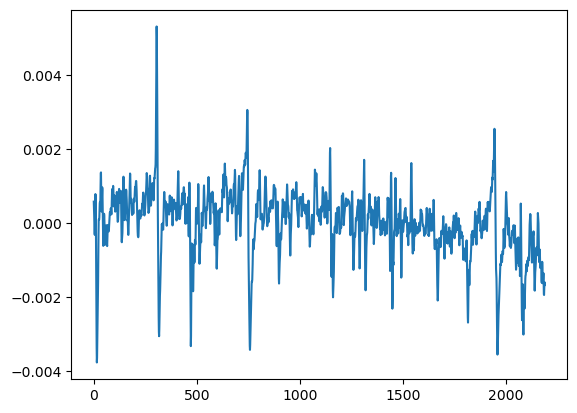

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1503fb8c4f70>

In [26]:
plt.plot(template)

In [27]:
dot(unit_template, unit_template)

1.0000000000000002

In [28]:
dot(template, template) / (template_length * template_length)

1.0000000000000002

In [29]:
shifted_template = circshift(template,(1,0))
dot(shifted_template, template) / (template_length * template_length)

0.9655151736361597

In [30]:
shifted_template = circshift(template,(2,0))
dot(shifted_template, template) / (template_length * template_length)

0.881397699677214

In [31]:
template_length * template_length

0.0016759881139123357

In [32]:
size(template)

(2189, 1)

In [33]:
masked_snrs;

In [34]:
test_residuals = my_residuals[:,2:2:end];

In [35]:
residuals_to_use = my_residuals

dot_products = zeros(size(residuals_to_use,2))
println(template_length)
for i in 1:size(residuals_to_use,2)
    spectrum = residuals_to_use[:,i]
    spectrum_length = sqrt(sum(spectrum.^2))
    # println(size(spectrum), size(template))
    # println(spectrum_length)
    dot_products[i] = dot(spectrum, template);
    # println(dot_products[i])
end

0.040938833812314876


In [36]:
py"""
from scipy.stats import binned_statistic_2d
"""

In [37]:
size(dot_products)

(65186,)

In [38]:
size(masked_snrs)

(65186,)

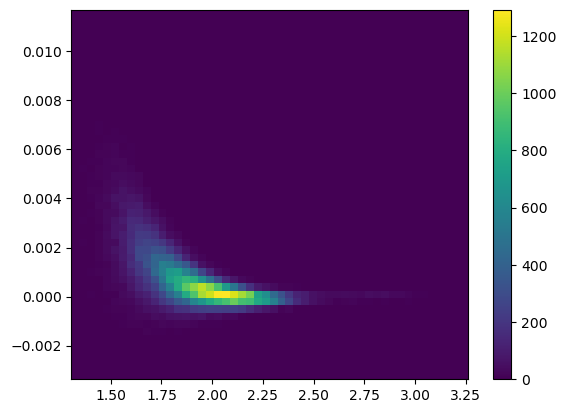

PyObject <matplotlib.colorbar.Colorbar object at 0x1503fb731780>

In [39]:
plt.hist2D(log10.(masked_snrs), dot_products, bins = 50)
plt.colorbar()
# plt.ylim(-0.05, 0.05)
# plt.xlim(0,250)

In [40]:
binned_dot_products = py"binned_statistic_2d"(log10.(SNR_lst[msk_inter][ps1]), masked_teffs, dot_products, bins=20);
size(binned_dot_products[1])

(20, 20)

In [41]:
log10(masked_snrs[20000])

1.796070167902338

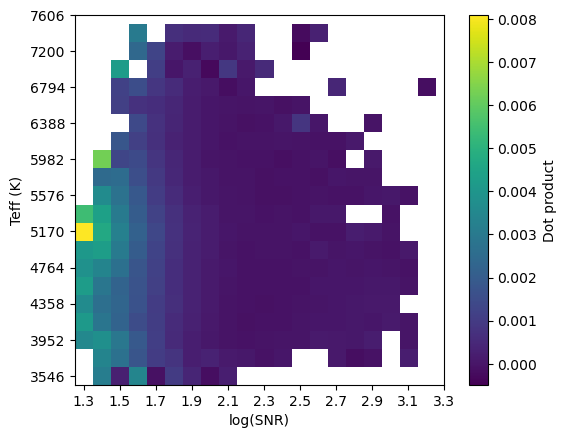

In [42]:
plt.imshow(binned_dot_products[1]')
plt.xticks(0:2:length(binned_dot_products[2]),round.(binned_dot_products[2],digits=1)[1:2:end])
plt.yticks(0:2:length(binned_dot_products[3]),round.(Int16,binned_dot_products[3])[1:2:end])
plt.xlabel("log(SNR)")
plt.ylabel("Teff (K)")
plt.gca().invert_yaxis()
c = plt.colorbar()
c.set_label("Dot product")

In [43]:
binned_dot_products_logg = py"binned_statistic_2d"(log10.(SNR_lst[msk_inter][ps1]), masked_logg, dot_products, bins=20);
size(binned_dot_products_logg[1])

(20, 20)

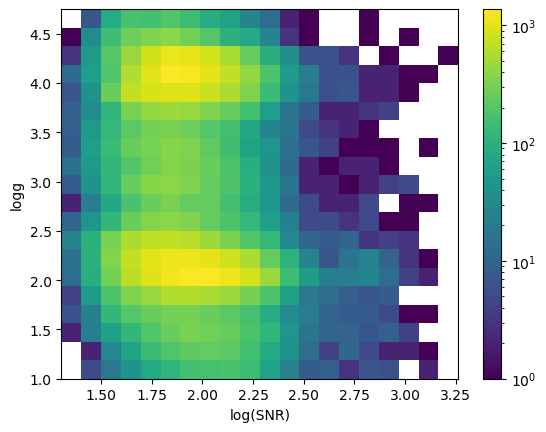

PyObject Text(24.000000000000007, 0.5, 'logg')

In [44]:
plt.hist2D(log10.(SNR_lst[msk_inter][ps1]), masked_logg, bins=20, norm = mplcolors.LogNorm())
plt.colorbar()
plt.xlabel("log(SNR)")
plt.ylabel("logg")

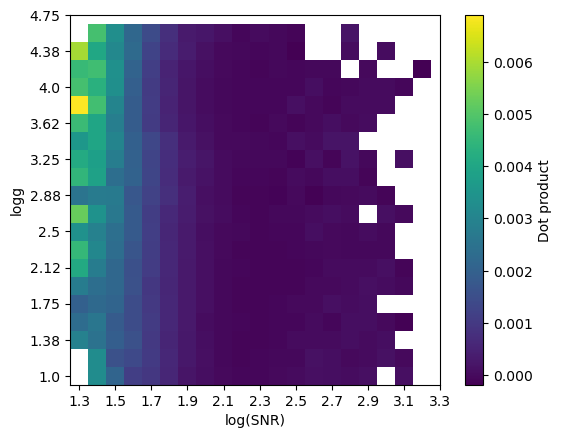

In [45]:
plt.imshow(binned_dot_products_logg[1]')
plt.xticks(0:2:length(binned_dot_products_logg[2]),round.(binned_dot_products_logg[2],digits=1)[1:2:end])
plt.yticks(0:2:length(binned_dot_products_logg[3]),round.(binned_dot_products_logg[3], digits=2)[1:2:end])
plt.xlabel("log(SNR)")
plt.ylabel("logg")
plt.gca().invert_yaxis()
c = plt.colorbar()
c.set_label("Dot product")

In [46]:
binned_dot_products_mh = py"binned_statistic_2d"(log10.(SNR_lst[msk_inter][ps1]), masked_mh, dot_products, bins=20);
size(binned_dot_products_mh[1])

(20, 20)

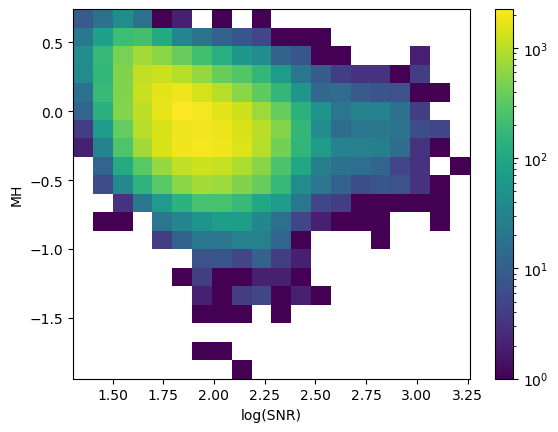

PyObject Text(24.000000000000007, 0.5, 'MH')

In [47]:
plt.hist2D(log10.(SNR_lst[msk_inter][ps1]), masked_mh, bins=20, norm = mplcolors.LogNorm())
plt.colorbar()
plt.xlabel("log(SNR)")
plt.ylabel("MH")

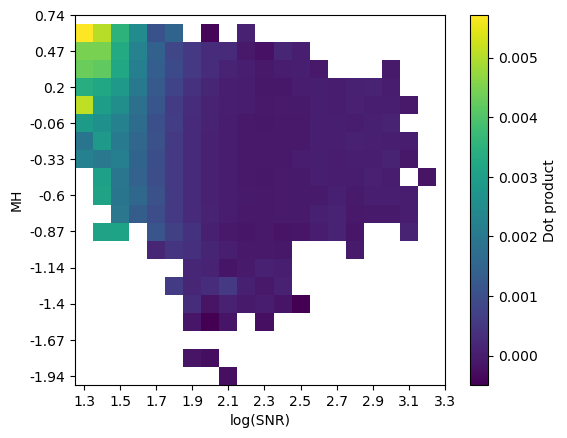

In [48]:
plt.imshow(binned_dot_products_mh[1]')
plt.xticks(0:2:length(binned_dot_products_mh[2]),round.(binned_dot_products_mh[2],digits=1)[1:2:end])
plt.yticks(0:2:length(binned_dot_products_mh[3]),round.(binned_dot_products_mh[3], digits=2)[1:2:end])
plt.xlabel("log(SNR)")
plt.ylabel("MH")
plt.gca().invert_yaxis()
c = plt.colorbar()
c.set_label("Dot product")

In [49]:
binned_dot_products_2 = py"binned_statistic_2d"(masked_teffs[2:2:20000], masked_logg[2:2:20000], dot_products[1:10000], bins=20);
size(binned_dot_products_2[1])

(20, 20)

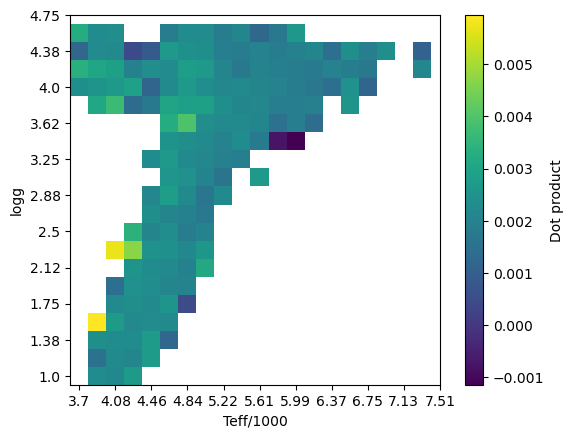

In [50]:
plt.imshow(binned_dot_products_2[1]')
plt.xticks(0:2:length(binned_dot_products_2[2]),round.(binned_dot_products_2[2]/1000,digits=2)[1:2:end])
plt.yticks(0:2:length(binned_dot_products_2[3]),round.(binned_dot_products_2[3], digits=2)[1:2:end])
plt.ylabel("logg")
plt.xlabel("Teff/1000")
plt.gca().invert_yaxis()
c = plt.colorbar()
c.set_label("Dot product")

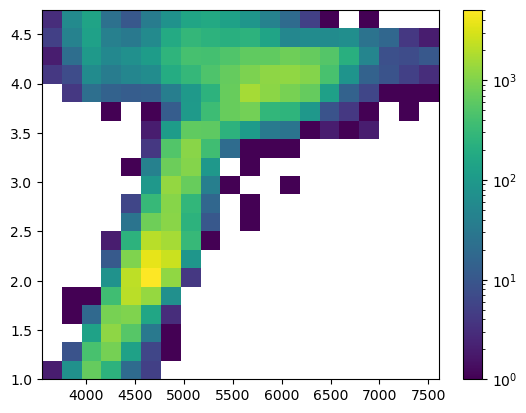

In [115]:
plt.hist2D( masked_teffs, masked_logg, bins=20, norm = mplcolors.LogNorm())
plt.colorbar()
plt.show()

In [52]:
snr_bins = binned_dot_products[2]
temp_bins = binned_dot_products[3];

In [53]:
print(snr_bins[8]," ", snr_bins[9]," ", temp_bins[6]," ", temp_bins[7])

1.9898278284800817 2.0876375055520833 4561.0 4764.0

75002


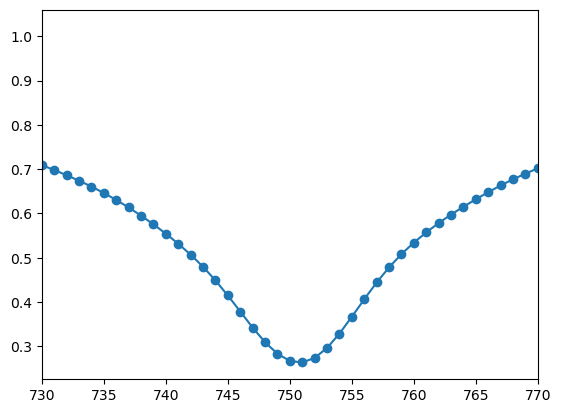

75002

In [54]:
mask =  snr_bins[8] .< log10.(masked_snrs) .< snr_bins[9] .&& temp_bins[6] .< masked_teffs .< temp_bins[7]
template = mean(masked_fluxes[:,mask], dims=2);
interp_linear = linear_interpolation(1:2189, template[:,1])
smooth_template = interp_linear(1:0.01:2189)
plt.scatter(1:2189, template)
plt.plot(1:0.01:2189, smooth_template)

xlim(730,770)
println(73000 + argmin(smooth_template[73000:77000]))
template_argmin = 73000 + argmin(smooth_template[73000:77000])

In [55]:
average_pixels_off = zeros(length(snr_bins), length(temp_bins));

for i in 1:length(snr_bins)-1
    for j in 1:length(temp_bins)-1
        mask =  snr_bins[i] .< log10.(masked_snrs) .< snr_bins[i + 1] .&& temp_bins[j] .< masked_teffs .< temp_bins[j + 1]
        average_signal = mean(masked_fluxes[:,mask], dims=2);
        interp_linear = linear_interpolation(1:2189, average_signal[:,1])
        smooth_signal = interp_linear(1:0.01:2189)
        
        # if i == 1 && j == 1
        #     plt.plot(smooth_signal[7300:7700])
        #     println(argmin(smooth_signal[7300:7700]))
        #     # xlim(730,770)
        # end
        
        signal_argmin = 73000 + argmin(smooth_signal[73000:77000])
        if signal_argmin > 73001 && ~(signal_argmin == 75002)
            println(i, " ", j, " ", signal_argmin)
        end
        if signal_argmin == 73001
            average_pixels_off[i,j] = NaN
        else
            average_pixels_off[i,j] = (signal_argmin - template_argmin)/100
        end
        
    end
end

1 4 74902
1 7 74902
1 9 74902
2 12 75102
2 13 74902
3 1 74902
3 13 74902
3 17 74902
4 20 74802
6 2 74902
6 20 74902
7 1 74902
8 20 74902
9 1 74902
9 18 74902


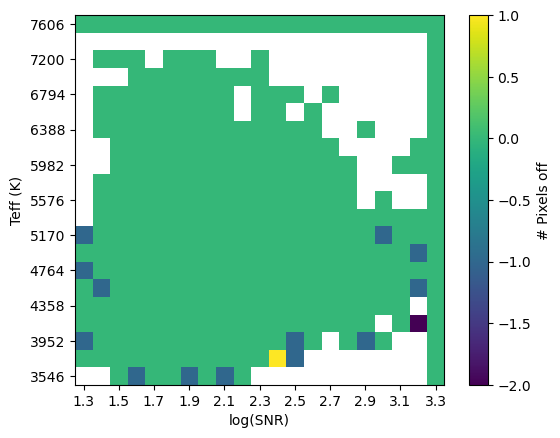

In [56]:
plt.imshow(average_pixels_off)
plt.xticks(0:2:length(binned_dot_products[2]),round.(binned_dot_products[2],digits=1)[1:2:end])
plt.yticks(0:2:length(binned_dot_products[3]),round.(Int16,binned_dot_products[3])[1:2:end])
plt.xlabel("log(SNR)")
plt.ylabel("Teff (K)")
plt.gca().invert_yaxis()
c = plt.colorbar()
c.set_label("# Pixels off")

In [57]:
binned_dot_products_2
logg_bins = binned_dot_products_2[3]
temp_bins = binned_dot_products_2[2];

In [76]:
temp_bins[7]

4843.7f0

In [79]:
logg_bins[16]

3.8125f0

4.0 - 4.1875 4843.7 - 5034.15
195
(2189, 49)


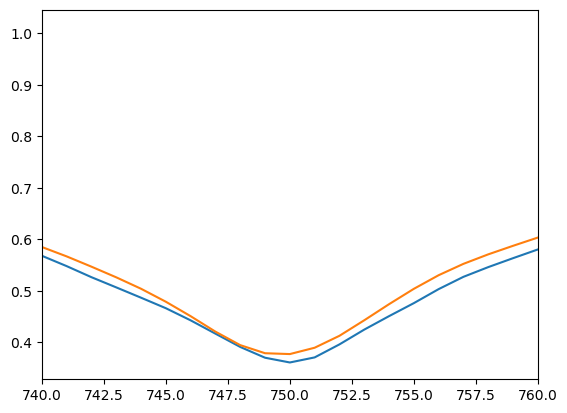

-0.011359312693100016

In [127]:
average_difference = zeros(length(snr_bins), length(temp_bins));

# for i in 1:length(logg_bins)-1
#     for j in 1:length(temp_bins)-1

j = 7
i = 17

println(logg_bins[i], " - ", logg_bins[i + 1], " ", temp_bins[j], " - ",temp_bins[j + 1])

mask =  logg_bins[i] .< masked_logg .< logg_bins[i + 1] .&& temp_bins[j] .< masked_teffs .< temp_bins[j + 1]
spectra_in_bin = masked_fluxes[:,mask]
number_spectra = size(spectra_in_bin,2)
# if number_spectra > 250
println(number_spectra)
first_quartile = round(Int16, number_spectra*0.25)
third_quartile = round(Int16, number_spectra*0.75)
most_noisy_spectrum = mean(spectra_in_bin[:,1:first_quartile], dims=2)
println(size(spectra_in_bin[:,1:first_quartile]))
least_noisy_spectrum = mean(spectra_in_bin[:,third_quartile:end], dims=2)
# if number_spectra > 4000
# plt.plot(most_noisy_spectrum - least_noisy_spectrum)
plt.plot(most_noisy_spectrum)

plt.plot(least_noisy_spectrum)

# plt.xlim(300,320)
# plt.xlim(1940,1960)
plt.xlim(740,760)

plt.show()

# end
difference = mean(most_noisy_spectrum - least_noisy_spectrum)
average_difference[j,i] = difference

# end
        
#     end
# end

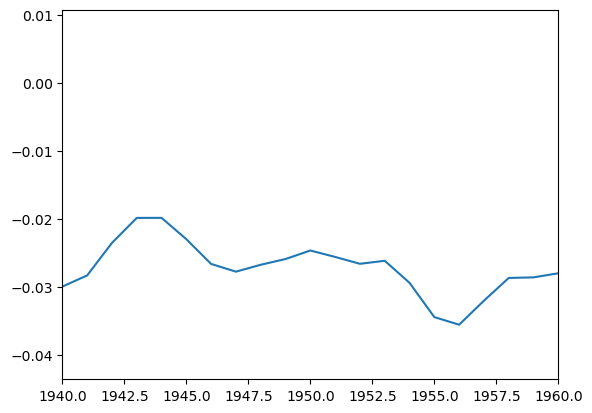

-0.02715542194266277

In [112]:
plt.plot(most_noisy_spectrum - least_noisy_spectrum)
plt.xlim(1940,1960)

plt.show()
mean((most_noisy_spectrum - least_noisy_spectrum)[1940:1960])

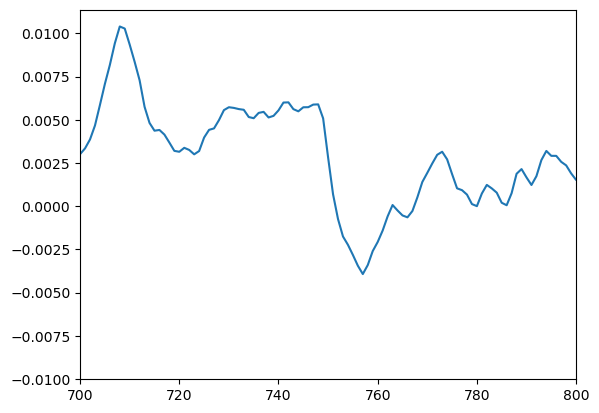

In [124]:
average_difference = zeros(length(snr_bins), length(temp_bins));

for i in 1:length(logg_bins)-1
    for j in 1:length(temp_bins)-1
        mask =  logg_bins[i] .< masked_logg .< logg_bins[i + 1] .&& temp_bins[j] .< masked_teffs .< temp_bins[j + 1]
        spectra_in_bin = masked_fluxes[:,mask]
        number_spectra = size(spectra_in_bin,2)
        if number_spectra > 50
            # println(number_spectra)
            first_quartile = round(Int16, number_spectra*0.25)
            third_quartile = round(Int16, number_spectra*0.75)
            most_noisy_spectrum = mean(spectra_in_bin[:,1:first_quartile], dims=2)
            least_noisy_spectrum = mean(spectra_in_bin[:,third_quartile:end], dims=2)
            if number_spectra > 4000
                plt.plot(most_noisy_spectrum - least_noisy_spectrum)
                plt.xlim(700,800)
                
                plt.show()
            end
            difference = mean((most_noisy_spectrum - least_noisy_spectrum)[1940:1960])
            average_difference[j,i] = difference

        end
        
    end
end

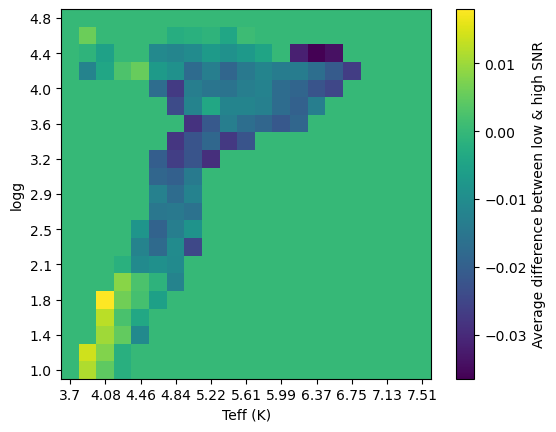

In [125]:
plt.imshow((average_difference'))
plt.yticks(0:2:length(logg_bins),round.(logg_bins,digits=1)[1:2:end])
plt.xticks(0:2:length(temp_bins),round.(temp_bins/1000,digits=2)[1:2:end])
plt.ylabel("logg")
plt.xlabel("Teff (K)")
plt.gca().invert_yaxis()
c = plt.colorbar()
c.set_label("Average difference between low & high SNR")

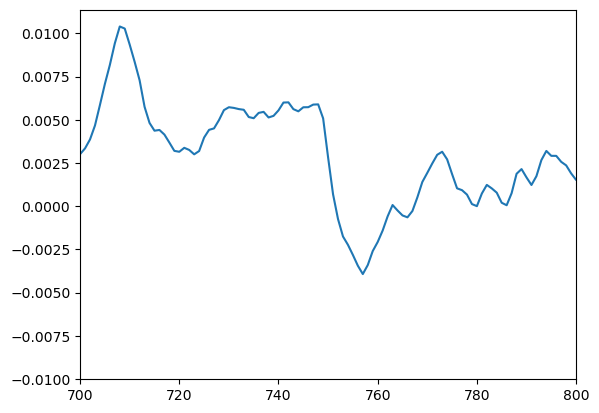

In [122]:
average_difference = zeros(length(snr_bins), length(temp_bins));

for i in 1:length(logg_bins)-1
    for j in 1:length(temp_bins)-1
        mask =  logg_bins[i] .< masked_logg .< logg_bins[i + 1] .&& temp_bins[j] .< masked_teffs .< temp_bins[j + 1]
        spectra_in_bin = masked_fluxes[:,mask]
        number_spectra = size(spectra_in_bin,2)
        if number_spectra > 50
            # println(number_spectra)
            first_quartile = round(Int16, number_spectra*0.25)
            third_quartile = round(Int16, number_spectra*0.75)
            most_noisy_spectrum = mean(spectra_in_bin[:,1:first_quartile], dims=2)
            least_noisy_spectrum = mean(spectra_in_bin[:,third_quartile:end], dims=2)
            if number_spectra > 4000
                plt.plot(most_noisy_spectrum - least_noisy_spectrum)
                plt.xlim(700,800)
                
                plt.show()
            end
            difference = mean((most_noisy_spectrum - least_noisy_spectrum)[320:340])
            average_difference[j,i] = difference

        end
        
    end
end

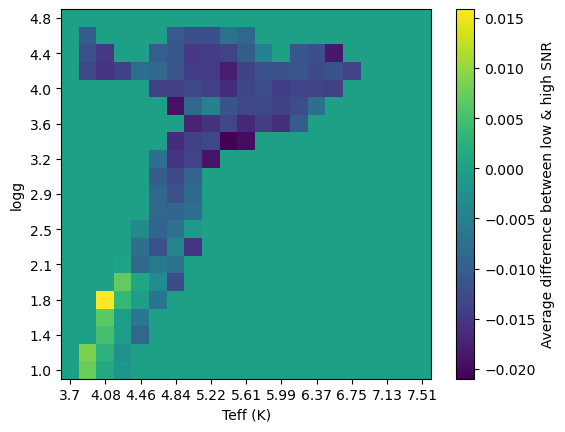

In [123]:
plt.imshow((average_difference'))
plt.yticks(0:2:length(logg_bins),round.(logg_bins,digits=1)[1:2:end])
plt.xticks(0:2:length(temp_bins),round.(temp_bins/1000,digits=2)[1:2:end])
plt.ylabel("logg")
plt.xlabel("Teff (K)")
plt.gca().invert_yaxis()
c = plt.colorbar()
c.set_label("Average difference between low & high SNR")

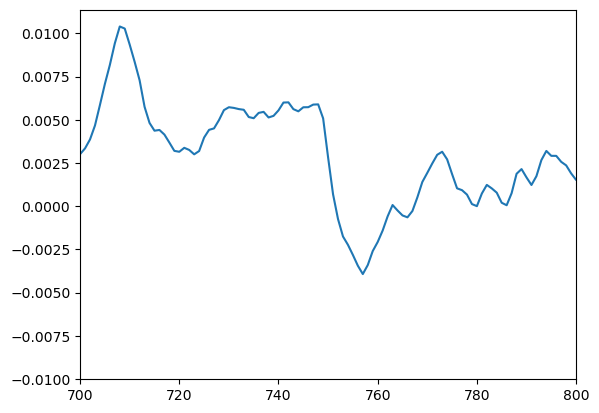

In [128]:
average_difference = zeros(length(snr_bins), length(temp_bins));

for i in 1:length(logg_bins)-1
    for j in 1:length(temp_bins)-1
        mask =  logg_bins[i] .< masked_logg .< logg_bins[i + 1] .&& temp_bins[j] .< masked_teffs .< temp_bins[j + 1]
        spectra_in_bin = masked_fluxes[:,mask]
        number_spectra = size(spectra_in_bin,2)
        if number_spectra > 50
            # println(number_spectra)
            first_quartile = round(Int16, number_spectra*0.25)
            third_quartile = round(Int16, number_spectra*0.75)
            most_noisy_spectrum = mean(spectra_in_bin[:,1:first_quartile], dims=2)
            least_noisy_spectrum = mean(spectra_in_bin[:,third_quartile:end], dims=2)
            if number_spectra > 4000
                plt.plot(most_noisy_spectrum - least_noisy_spectrum)
                plt.xlim(700,800)
                
                plt.show()
            end
            difference = mean((most_noisy_spectrum - least_noisy_spectrum)[740:760])
            average_difference[j,i] = difference

        end
        
    end
end

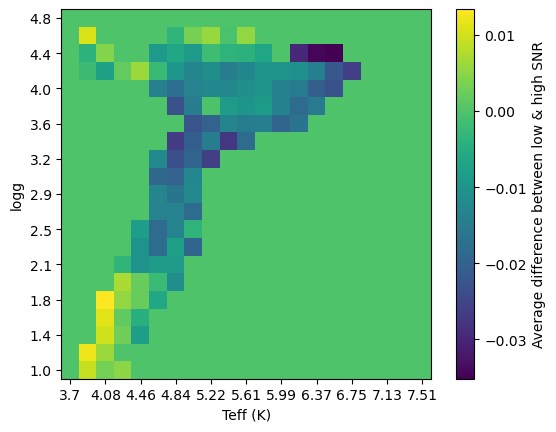

In [129]:
plt.imshow((average_difference'))
plt.yticks(0:2:length(logg_bins),round.(logg_bins,digits=1)[1:2:end])
plt.xticks(0:2:length(temp_bins),round.(temp_bins/1000,digits=2)[1:2:end])
plt.ylabel("logg")
plt.xlabel("Teff (K)")
plt.gca().invert_yaxis()
c = plt.colorbar()
c.set_label("Average difference between low & high SNR")

In [60]:
basework = "/uufs/chpc.utah.edu/common/home/u6039752/scratch/working/"
Cstar = h5read(basework*"/2022_11_28/priors/RVS_stellar_zeroweighted_kry_50_95_const.h5","Cstar"); 

In [61]:
size(Cstar)

(2189, 2189)

In [62]:
using KrylovKit
vals, vecs, info = eigsolve(Cstar, 10,:LM);

In [63]:
size(vecs[1])

(2189,)

In [64]:
dot(template, vecs[2])

4.9880324988330385

In [133]:
for i in 1:10
    println(dot(template, vecs[i]) / template_length," ", sqrt(vals[i]))
end

1080.098915553044 14.80252102153215
121.84109888671476 4.674082249122071
4.0608178169536995 0.42417359924468545
-0.062398425812720225 0.17900881576502284
2.0482813241048192 0.142004852110026
-0.975729504339409 0.11095673130031482
-0.3683295340371065 0.057185488487745524
-0.16434492034682555 0.05020898590804748
0.016425757836214756 0.04223188241108587
-0.14052356128073354 0.03487217105317941


In [130]:
for i in 1:10
    println(mean(vecs[i])," ", sqrt(vals[i]))
end

0.021373497354228388 14.80252102153215
5.382351948983105e-5 4.674082249122071
1.773510835014759e-5 0.42417359924468545
-1.0149149187128014e-6 0.17900881576502284
-8.188004502737642e-7 0.142004852110026
2.534024574187493e-7 0.11095673130031482
-1.600203133600248e-7 0.057185488487745524
-4.2328424839713315e-8 0.05020898590804748
-3.19758966269237e-7 0.04223188241108587
1.3966799412358092e-9 0.03487217105317941


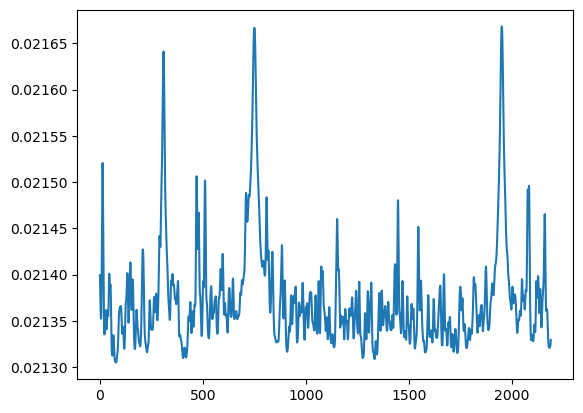

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1503d0be0130>

In [132]:
plt.plot(vecs[1])

In [134]:
files_arr = []

for (root, dirs, files) in walkdir("../test_gaia_data1/")
    files_arr = joinpath.(root, files)
    break
    # operate_on_files(joinpath.(root, files)) # files is a Vector{String}, can be empty
end

In [135]:
noises = []
residuals = []
sample_means = []
stellar_components = []
i = 0
for file in files_arr
    μ_cd_mat_random = h5read(file,"μ_cd");
    μ_bd_mat_random = h5read(file,"μ_bd");
    # print(μ_cd_mat_random)
    # print((isnan(μ_bd_mat_random)))
    # noise_factors = h5read(file,"noise_factor");
    # sample_mean = h5read(file,"sampleMean");
    batch_residuals = 100 .*μ_cd_mat_random./μ_bd_mat_random;
    # print(size(batch_residuals))
    # batch_residuals = 100 .*μ_cd_mat_random./μ_bd_mat_random;

    # println(size(batch_residuals)," ", size(noise_factors))
    # noises = cat(noises, noise_factors, dims = 1)
    residuals = cat(residuals, batch_residuals', dims = 1)
    stellar_components = cat(stellar_components, μ_bd_mat_random', dims = 1)
    # sample_means = cat(sample_means, sample_mean, dims = 1)
end

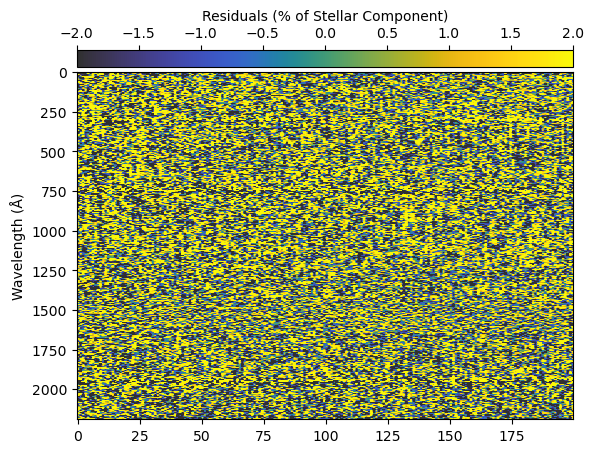

In [140]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

median_subtracted_residuals = residuals'[star_msk,:] .- median(residuals[:,star_msk],dims =1)'

img = ax.imshow(residuals'[star_msk,:],
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-2,
    vmax=2,
    # extent=(0,200,775,750),
    # extent=(0,size(sorted_residuals',2),maxw,minw),
)
# plt.ylim(750,775)
# plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
cax.set_xlabel("Residuals (% of Stellar Component)")
plt.show()